In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

os.chdir('/Users/hausfath/Desktop/Climate Science/Carbon Brief/UK CO2 declines/')

In [127]:
#Constants

MWH_PER_TWH = 1000000.
IMP_GAL_PER_TON = 220.
CO2_KG_GALLON_PETROL = 8.89
CO2_KG_GALLON_DIESEL = 10.16


#General functions
def lower(df):
    df.columns = [x.lower() for x in df.columns]
    return df

In [203]:
#Import data from spreadsheets

elec_fuel_mtoe = lower(pd.read_excel('UK energy stats.xlsx', sheet_name='Electric fuel mtoe'))
fuel_mtoe = lower(pd.read_excel('UK energy stats.xlsx', sheet_name='Total fuel mtoe'))
fuel_co2 = lower(pd.read_excel('UK energy stats.xlsx', sheet_name='CO2 by fuel'))
elec_twh = lower(pd.read_excel('UK energy stats.xlsx', sheet_name='Electric gen twh'))
co2_sources = lower(pd.read_excel('UK energy stats.xlsx', sheet_name='CO2 sources 2'))
elec_co2 = lower(pd.read_excel('UK energy stats.xlsx', sheet_name='CO2 electric'))
elec_sector = lower(pd.read_excel('UK energy stats.xlsx', sheet_name='Electric sector'))
pop = lower(pd.read_excel('UK population.xlsx'))
vehicle_miles = lower(pd.read_excel('transportation.xlsx', sheet_name='miles traveled'))
transport_fuel = lower(pd.read_excel('transportation.xlsx', sheet_name='fuel use'))
transport_co2 = lower(pd.read_excel('transportation.xlsx', sheet_name='CO2 emissions'))

In [204]:
#Calculate CO2 per mtoe for each fuel

co2_per_mtoe = pd.DataFrame()
co2_per_mtoe['coal'] = fuel_co2['coal'] / fuel_mtoe['coal']
co2_per_mtoe['gas'] = fuel_co2['gas'] / fuel_mtoe['gas']
co2_per_mtoe['oil'] = fuel_co2['oil'] / fuel_mtoe['oil']

#Backfill missing values (fix this by getting pre-1995 mtoe by fuel)
co2_per_mtoe.fillna(method='backfill', inplace=True)

#Calculate total CO2 from electricity generation

elec_co2['total'] = elec_co2['coal'] + elec_co2['gas'] + elec_co2['oil'] + elec_co2['other fuels']

In [205]:
#Calculate generation efficiency by fuel

gen_eff = pd.DataFrame()
gen_eff['coal'] = elec_twh['coal'] / elec_fuel_mtoe['coal']
gen_eff['gas'] = elec_twh['gas'] / elec_fuel_mtoe['gas']
gen_eff['oil'] = elec_twh['oil'] / elec_fuel_mtoe['oil']
gen_eff['nuclear'] = elec_twh['nuclear'] / elec_fuel_mtoe['nuclear']
gen_eff['hydro'] = elec_twh['hydro'] / elec_fuel_mtoe['hydro']
gen_eff['bioenergy'] = elec_twh['bioenergy'] / elec_fuel_mtoe['bioenergy']

#Backfill missing values (fix this by getting pre-1998 electric TWh by fuel)
gen_eff.fillna(method='backfill', inplace=True)


elec_twh['total_est'] = (elec_twh['coal'] + elec_twh['gas'] + elec_twh['oil'] + elec_twh['nuclear'] 
+ elec_twh['hydro'] + elec_twh['bioenergy'] + elec_twh['wind'] + elec_twh['solar'] + elec_twh['other fuels'])

#Calculate the 1990 grid mix percents by fuel:

#elec_twh['coal_%'] = elec_twh['coal'] / elec_twh['total_est']

grid_mix = {}
for name, values in elec_twh.iteritems():
    grid_mix["{}".format(name)] = elec_twh[name].values / elec_twh['total_est'].values

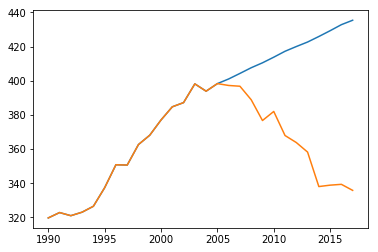

In [206]:
#Create a counterfactual total energy use scenario where per-capita usage is constant post-2005

cf = pop.copy()
per_capita_mwh = (elec_twh['total_est'].values * MWH_PER_TWH) / cf['population']
cf['counterfact_twh'] = per_capita_mwh.values[15] * cf['population'] / MWH_PER_TWH

cf.loc[cf['year'] < 2005, 'counterfact_twh'] = np.nan
cf['counterfact_twh'] = np.where(cf['counterfact_twh'].notnull(), cf['counterfact_twh'], elec_twh['total_est'])

#Graph it to see what it looks like

plt.plot(cf['year'], cf['counterfact_twh'], '', cf['year'], elec_twh['total_est'])
plt.show()

#Create counterfactual energy use by fuel assuming constant 1990 grid mix

cf['coal'] = grid_mix['coal'][0] * cf['counterfact_twh']
cf['gas'] = grid_mix['gas'][0] * cf['counterfact_twh']
cf['oil'] = grid_mix['oil'][0] * cf['counterfact_twh']
cf['nuclear'] = grid_mix['nuclear'][0] * cf['counterfact_twh']
cf['hydro'] = grid_mix['hydro'][0] * cf['counterfact_twh']
cf['bioenergy'] = grid_mix['bioenergy'][0] * cf['counterfact_twh']
cf['wind'] = grid_mix['wind'][0] * cf['counterfact_twh']
cf['solar'] = grid_mix['solar'][0] * cf['counterfact_twh']
cf['other fuels'] = grid_mix['other fuels'][0] * cf['counterfact_twh']
cf['total'] = (cf['coal'] + cf['gas'] + cf['oil'] + cf['nuclear'] 
+ cf['hydro'] + cf['bioenergy'] + cf['wind'] + cf['solar'] + cf['other fuels'])

grid_mix_cf = {}
for name, values in cf.iteritems():
    grid_mix_cf["{}".format(name)] = cf[name].values / cf['total'].values


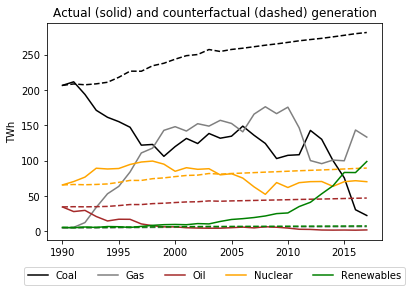

In [207]:
#Plot grid mix comparisons:

cf['renew'] = cf['hydro'] + cf['bioenergy'] + cf['wind'] + cf['solar']
elec_twh['renew'] = elec_twh['hydro'] + elec_twh['bioenergy'] + elec_twh['wind'] + elec_twh['solar']

plt.plot(cf['year'], elec_twh['coal'], color='black', label="Coal")
plt.plot(cf['year'], cf['coal'], linestyle='--', color='black', label="")
plt.plot(cf['year'], elec_twh['gas'], color='grey', label="Gas")
plt.plot(cf['year'], cf['gas'], linestyle='--', color='grey', label="")
plt.plot(cf['year'], elec_twh['oil'], color='brown', label="Oil")
plt.plot(cf['year'], cf['oil'], linestyle='--', color='brown', label="")
plt.plot(cf['year'], elec_twh['nuclear'], color='orange', label="Nuclear")
plt.plot(cf['year'], cf['nuclear'], linestyle='--', color='orange', label="")
plt.plot(cf['year'], elec_twh['renew'], color='green', label="Renewables")
plt.plot(cf['year'], cf['renew'], linestyle='--', color='green', label="")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=25)


#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, borderaxespad=0.)
plt.ylabel('TWh')
plt.title('Actual (solid) and counterfactual (dashed) generation')
plt.show()

em_save = cf.copy()
em_save['coal_base'] = elec_twh['coal'].values
em_save['gas_base'] = elec_twh['gas'].values
em_save['oil_base'] = elec_twh['oil'].values
em_save['nuclear_base'] = elec_twh['nuclear'].values
em_save['renew_base'] = elec_twh['renew'].values


em_save[['year', 'coal', 'coal_base', 'gas', 'gas_base','oil', 'oil_base','nuclear', 'nuclear_base','renew', 'renew_base',]].to_csv('grid_mix_results.csv')



In [208]:
#Calculate reductions by source:

elec_twh['grid_ef_kg_kwh'] = co2_sources['power stations'] / elec_twh['total_est']
cf['grid_ef_kg_kwh'] = elec_twh['grid_ef_kg_kwh'].values[0]
cf['coal_ef'] = elec_co2['coal'].values / elec_twh['coal'].values
cf['gas_ef'] = elec_co2['gas'].values / elec_twh['gas'].values
cf['oil_ef'] = elec_co2['oil'].values / elec_twh['oil'].values
cf['cf_ef'] = (cf['coal'] * cf['coal_ef'].values + cf['gas'] * cf['gas_ef'] + cf['oil'] * cf['oil_ef']) / cf['total']

cf['percent_change'] = (grid_mix_cf['coal'] - grid_mix['coal']) + (grid_mix_cf['oil'] - grid_mix['oil'])
cf['replacement_co2_avg'] = ((grid_mix_cf['coal'] - grid_mix['coal']) * cf['coal_ef'] + (grid_mix_cf['oil'] - grid_mix['oil']) * cf['oil_ef'].values[0]) / (cf['percent_change'] + 0.01)

cf['ff_co2_nogas'] = (cf['coal_ef'] * grid_mix_cf['coal'] + cf['oil_ef'] * grid_mix_cf['oil']) / (grid_mix_cf['coal'] + grid_mix_cf['oil'])

cf['gas_reduction'] = (elec_twh['total_est'].values * (grid_mix['gas'] - grid_mix_cf['gas']) * (cf['replacement_co2_avg'] - cf['gas_ef']))

cf['wind_reduction'] = (elec_twh['total_est'].values * (grid_mix['wind'] - grid_mix_cf['wind']) * cf['replacement_co2_avg'])

cf['solar_reduction'] = (elec_twh['total_est'].values * (grid_mix['solar'] - grid_mix_cf['solar']) * cf['replacement_co2_avg'])

cf['bio_reduction'] = (elec_twh['total_est'].values * (grid_mix['bioenergy'] - grid_mix_cf['bioenergy']) * cf['replacement_co2_avg'])

cf['nuclear_reduction'] = (elec_twh['total_est'].values * (grid_mix['nuclear'] - grid_mix_cf['nuclear']) * cf['replacement_co2_avg'])

cf['eff_reduction'] = (cf['total'] - elec_twh['total_est'].values) * cf['cf_ef']

cf['actual_co2'] = co2_sources['power stations'].values

cf[['year', 'actual_co2', 'gas_reduction', 'wind_reduction', 'solar_reduction', 'nuclear_reduction', 'bio_reduction', 'eff_reduction']].to_csv('electric_co2_results.csv')

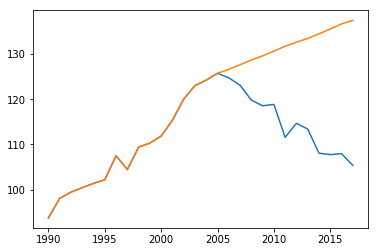

In [209]:
#Calculate counterfactuals by sector

per_capita_mwh = (elec_sector['industrial'].values * MWH_PER_TWH) / cf['population']
elec_sector['industrial_alt'] = per_capita_mwh.values[15] * cf['population'] / MWH_PER_TWH

elec_sector.loc[elec_sector['year'] < 2005, 'industrial_alt'] = np.nan
elec_sector['industrial_alt'] = np.where(elec_sector['industrial_alt'].notnull(), elec_sector['industrial_alt'], elec_sector['industrial'])

per_capita_mwh = (elec_sector['commercial'].values * MWH_PER_TWH) / cf['population']
elec_sector['commercial_alt'] = per_capita_mwh.values[15] * cf['population'] / MWH_PER_TWH

elec_sector.loc[elec_sector['year'] < 2005, 'commercial_alt'] = np.nan
elec_sector['commercial_alt'] = np.where(elec_sector['commercial_alt'].notnull(), elec_sector['commercial_alt'], elec_sector['commercial'])

per_capita_mwh = (elec_sector['residential'].values * MWH_PER_TWH) / cf['population']
elec_sector['residential_alt'] = per_capita_mwh.values[15] * cf['population'] / MWH_PER_TWH

elec_sector.loc[elec_sector['year'] < 2005, 'residential_alt'] = np.nan
elec_sector['residential_alt'] = np.where(elec_sector['residential_alt'].notnull(), elec_sector['residential_alt'], elec_sector['residential'])



plt.plot(elec_sector['year'], elec_sector['residential'], '', elec_sector['year'], elec_sector['residential_alt'])
plt.show()



elec_sector[['year', 'industrial', 'industrial_alt', 'commercial', 'commercial_alt', 'residential', 'residential_alt']].to_csv('elec_sector_results.csv')



In [223]:
#Analyze transportation data

transport_fuel.fillna(method='ffill', inplace=True) #Replacing missing 2016 values with 2015 values
transport_co2.fillna(method='ffill', inplace=True) #Replacing missing 2016 values with 2015 values

trans = pd.DataFrame()
trans['year'] = transport_fuel['year'][20:]
trans['fuel_economy'] = (vehicle_miles['all motor vehicles'][41:68].values * 10**3) / (transport_fuel['total road'][20:].values * IMP_GAL_PER_TON) 
trans['per_cap_miles'] = (vehicle_miles['all motor vehicles'][41:68].values * 10**9) / cf['population'][0:27].values
trans['vehicle_miles'] = vehicle_miles['all motor vehicles'][41:68].values

trans['other_co2'] = (transport_co2['rail'].values + transport_co2['domestic aviation'].values +
                      transport_co2['domestic shipping1'].values + transport_co2['other'].values)

#Create counterfactuals assuming constant per-capita behavior
trans['other_co2_alt'] = trans['other_co2'].values[0] / cf['population'].values[0] * cf['population'][0:27].values
trans['fuel_economy_alt'] = trans['fuel_economy'].values[0]
#miles traveled counterfactual relative to 2007 peak
trans['vehicle_miles_alt'] = trans['per_cap_miles'].values[17] * cf['population'][0:27].values / 10 ** 9
trans.loc[trans['year'] < 2007, 'vehicle_miles_alt'] = np.nan
trans['vehicle_miles_alt'] = np.where(trans['vehicle_miles_alt'].notnull(), trans['vehicle_miles_alt'], trans['vehicle_miles'])

#Estimate weighted average emission factor from petrol and diesel
trans['fuel_ef'] = (CO2_KG_GALLON_PETROL * transport_fuel['total petrol'][20:] + CO2_KG_GALLON_DIESEL * transport_fuel['total diesel'][20:]) / (transport_fuel['total petrol'][20:] + transport_fuel['total diesel'][20:])

#Reductions in million gallons
trans['alt_vehicle_fuel_use'] = (1 / trans['fuel_economy_alt']) * trans['vehicle_miles_alt'] * 1000
trans['vehicle_fuel_use'] = transport_fuel['total road'][20:].values * IMP_GAL_PER_TON
trans['fuel_econ_reduction'] = trans['alt_vehicle_fuel_use'] - ((1 / trans['fuel_economy']) * trans['vehicle_miles_alt'] * 1000)
trans['miles_driven_reduction'] = trans['alt_vehicle_fuel_use'] - ((1 / trans['fuel_economy_alt']) * trans['vehicle_miles'] * 1000)

#Normalize results to the total counterfactual reductions to avoid double-counting
trans['temp'] = trans['fuel_econ_reduction'] + trans['miles_driven_reduction']
trans['fuel_econ_reduction'] = trans['fuel_econ_reduction'] * ((trans['alt_vehicle_fuel_use'] - trans['vehicle_fuel_use']) / (trans['temp'] + 0.00001))
trans['miles_driven_reduction'] = trans['miles_driven_reduction'] * ((trans['alt_vehicle_fuel_use'] - trans['vehicle_fuel_use']) / (trans['temp'] + 0.00001))

#Convert from million gallons to million tonnes CO2
trans['fuel_econ_co2_reduction'] = trans['fuel_econ_reduction'] * trans['fuel_ef'] / 1000
trans['miles_driven_co2_reduction'] = trans['miles_driven_reduction'] * trans['fuel_ef'] / 1000
trans['other_co2_reduction'] = trans['other_co2_alt'] - trans['other_co2']

trans[['year', 'vehicle_miles', 'vehicle_miles_alt', 'fuel_economy', 'fuel_economy_alt', 'fuel_econ_co2_reduction', 'miles_driven_co2_reduction', 'other_co2_reduction']].to_csv('trans_sector_results.csv')

trans[['year','per_cap_miles']]


,year,per_cap_miles
20,1990,4460.362525
21,1991,4453.443410
22,1992,4447.377332
23,1993,4439.138578
24,1994,4526.278860
25,1995,4601.480746
26,1996,4712.504556
27,1997,4798.145220
28,1998,4872.175925
29,1999,4945.096141


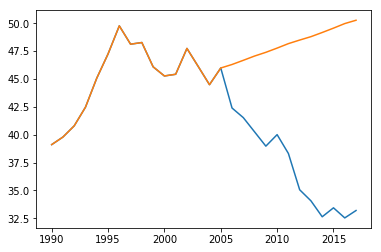

In [221]:
#Analyze direct combustion data

co2_sources['business total']
co2_sources['residential']
co2_sources['public and ag']
co2_sources['lulucf']
co2_sources['other energy supply']

#Create counterfactuals, choosing best year based on visual inspection

per_capita_co2 = co2_sources['business total'].values / cf['population']
co2_sources['business_alt'] = per_capita_co2.values[0] * cf['population']

per_capita_co2 = co2_sources['residential'].values / cf['population']
co2_sources['residential_alt'] = per_capita_co2.values[8] * cf['population']
co2_sources.loc[co2_sources['year'] < 1998, 'residential_alt'] = np.nan
co2_sources['residential_alt'] = np.where(co2_sources['residential_alt'].notnull(), co2_sources['residential_alt'], co2_sources['residential'])

per_capita_co2 = co2_sources['public and ag'].values / cf['population']
co2_sources['public and ag_alt'] = per_capita_co2.values[7] * cf['population']
co2_sources.loc[co2_sources['year'] < 1997, 'public and ag_alt'] = np.nan
co2_sources['public and ag_alt'] = np.where(co2_sources['public and ag_alt'].notnull(), co2_sources['public and ag_alt'], co2_sources['public and ag'])

per_capita_co2 = co2_sources['lulucf'].values / cf['population']
co2_sources['lulucf_alt'] = per_capita_co2.values[0] * cf['population']

per_capita_co2 = co2_sources['other energy supply'].values / cf['population']
co2_sources['other energy supply_alt'] = per_capita_co2.values[15] * cf['population']
co2_sources.loc[co2_sources['year'] < 2005, 'other energy supply_alt'] = np.nan
co2_sources['other energy supply_alt'] = np.where(co2_sources['other energy supply_alt'].notnull(), co2_sources['other energy supply_alt'], co2_sources['other energy supply'])

#Calculate CO2 reductions

co2_sources['business_reductions'] = co2_sources['business_alt'] - co2_sources['business total']
co2_sources['residential_reductions'] = co2_sources['residential_alt'] - co2_sources['residential']
co2_sources['public_ag_reductions'] = co2_sources['public and ag_alt'] - co2_sources['public and ag']
co2_sources['lulucf_reductions'] = co2_sources['lulucf_alt'] - co2_sources['lulucf']
co2_sources['other_energy_reductions'] = co2_sources['other energy supply_alt'] - co2_sources['other energy supply']

co2_sources[['year', 'business_alt', 'business total', 'residential_alt', 'residential', 'public and ag_alt', 'public and ag', 'lulucf_alt', 'lulucf', 'other energy supply_alt', 'other energy supply', 'business_reductions', 'residential_reductions', 'public_ag_reductions', 'lulucf_reductions', 'other_energy_reductions']].to_csv('other_sector_results.csv')

plt.plot(co2_sources['year'], co2_sources['other energy supply'], '', co2_sources['year'], co2_sources['other energy supply_alt'])
plt.show()


